In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import sys

# Get project root 
if 'Notebooks' in str(Path.cwd()) or 'notebooks' in str(Path.cwd()):
    project_root = Path.cwd().parent
else:
    project_root = Path.cwd()

# Add src to path FIRST
sys.path.append(str(project_root / 'src'))

from similarities_computation import run_similarity_analysis, run_explorations
from data_processing import extract_ranges, fill_singleton_dimensions
from data_visualisation import plot_scatter_for_variable_groups, plot_explorations
from generate_report import get_top_n_similarities, create_output_csv

# Task 2
---

## 1) Data Loading and Cleaning

In [2]:
# Load the data
task2_path = project_root / 'resources' / 'task_2'
df_properties = pd.read_csv(task2_path / 'reference_properties.tsv', sep='\t')
df_rfq = pd.read_csv(task2_path / 'rfq.csv')

In [3]:
df_rfq.head()

,id,grade,grade_suffix,coating,finish,surface_type,surface_protection,form,thickness_min,thickness_max,...,weight_min,weight_max,inner_diameter_min,inner_diameter_max,outer_diameter_min,outer_diameter_max,yield_strength_min,yield_strength_max,tensile_strength_min,tensile_strength_max
0,8aff426d-b8c0-43aa-ad26-835ef4de6129,S700MC,NaN,NaN,Oiled,NaN,NaN,Coils,6.0,6.0,...,15000.0,25000.0,610.0,610.0,NaN,NaN,NaN,NaN,760.0,810.0
1,37e624be-b125-464f-85b6-1838530193ef,S250GD,NaN,ZM310,Hot-dip zinc magnesium (+ZM),NaN,NaN,Slit Coils,1.5,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b8257184-6307-46ab-b06e-d979336d1263,DX51D,NaN,Z100,Hot-dip Galvanized (+Z/+GI),NaN,Lightly Oiled (L),Coils,0.4,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,63140d1f-dda8-40fe-8931-bcaba65d5772,S235,NaN,NaN,NaN,NaN,NaN,Round Tubes,1.5,1.5,...,53800.0,53800.0,NaN,NaN,60.3,NaN,NaN,NaN,NaN,NaN
4,11cffc57-44be-4d79-bfd5-97482be566d3,S235,NaN,NaN,NaN,NaN,NaN,Round Tubes,1.5,1.5,...,14500.0,14500.0,NaN,NaN,48.3,NaN,NaN,NaN,NaN,NaN


In [4]:
df_properties.head()

,Grade/Material,UNS_No,Steel_No,Standards,Carbon (C),Manganese (Mn),Silicon (Si),Sulfur (S),Phosphorus (P),Chromium (Cr),...,Reduction of area (Z%),"Hardness (HB, HV, HRC)",Impact toughness (Charpy V-notch),Fatigue limit,Creep resistance,Source_Pages,Application,Category,Nb + V + Ti (Others),Coating
0,S235JR,NaN,NaN,EN 10025-2:2019,≤0.17,≤1.40,≤0.40,≤0.035,≤0.035,NaN,...,NaN,NaN,27J at 20°C,NaN,NaN,Standard Specifications,General structural steels,Structural Steel,NaN,NaN
1,S275JR,NaN,NaN,EN 10025-2:2019,≤0.21,≤1.50,≤0.40,≤0.035,≤0.035,NaN,...,NaN,NaN,27J at 20°C,NaN,NaN,Standard Specifications,General structural steels,Structural Steel,NaN,NaN
2,S355JR,NaN,NaN,EN 10025-2:2019,≤0.24,≤1.60,≤0.55,≤0.035,≤0.035,NaN,...,NaN,NaN,27J at 20°C,NaN,NaN,Standard Specifications,General structural steels,Structural Steel,NaN,NaN
3,S420M,NaN,NaN,EN 10025-3:2019,≤0.20,1.00-1.70,≤0.50,≤0.025,≤0.030,≤0.30,...,NaN,NaN,27J at -20°C,NaN,NaN,Standard Specifications,Thermomechanically rolled steels,High Strength Steel,NaN,NaN
4,S460M,NaN,NaN,EN 10025-3:2019,≤0.20,1.00-1.70,≤0.50,≤0.025,≤0.030,≤0.30,...,NaN,NaN,27J at -20°C,NaN,NaN,Standard Specifications,Thermomechanically rolled steels,High Strength Steel,NaN,NaN


- I standardise all variables names: 
    - I substitute empty spaces with '_' 
    - I set everything to lowercase excepted materials abbreviations


In [5]:
# rename propertires columns
column_mapping = {
    'Standards': 'standards',
    'Carbon (C)': 'carbon_C',
    'Manganese (Mn)': 'manganese_Mn', 
    'Silicon (Si)': 'silicon_Si',
    'Sulfur (S)': 'sulfur_S',
    'Phosphorus (P)': 'phosphorus_P',
    'Chromium (Cr)': 'chromium_Cr',
    'Nickel (Ni)': 'nickel_Ni',
    'Molybdenum (Mo)': 'molybdenum_Mo',
    'Vanadium (V)': 'vanadium_V',
    'Aluminum (Al)': 'aluminum_Al',
    'Titanium (Ti)': 'titanium_Ti',
    'Niobium (Nb)': 'niobium_Nb',
    'Boron (B)': 'boron_B',
    'Nitrogen (N)': 'nitrogen_N',
    'Tensile strength (Rm)': 'tensile_strength_Rm',
    'Yield strength (Re or Rp0.2)': 'yield_strength_RE_RP0.2', 
    'Elongation (A%)': 'elongation_A%',
    'Hardness (HB, HV, HRC)': 'hardness_HB_HV_HRC',
    'Impact toughness (Charpy V-notch)': 'impact_toughness_Charpy_V_notch',
    'Source_Pages': 'source_pages',
    'Application': 'application',
    'Category': 'category',
    'Nb + V + Ti (Others)': 'Nb_V_Ti_others',
    'Coating': 'coating'
}

df_properties = df_properties.rename(columns=column_mapping)

- Some grades keys are inconsistent. They are duplicates with different labeling. 
- I kept only one version of the label and removed duplicates

In [6]:
# Fix inconsistencies in grade
df_properties['Grade/Material'] = df_properties['Grade/Material'].replace({
    'HC380La': 'HC380LA',
    '26Mnb5': '26MnB5',
    'CR440Y780T DP': 'CR440Y780T-DP'
})

df_rfq['grade'] = df_rfq['grade'].replace({
    'HC380La': 'HC380LA',
    '26Mnb5': '26MnB5',
    'CR440Y780T DP': 'CR440Y780T-DP'
})

# Clean duplicates after renaming
df_properties = df_properties.drop_duplicates(subset=['Grade/Material'], keep='first')

- I join both datasets on the grade/material column
- I check for potential no matches in grades (none found)

In [7]:
# join datasets
df_merged = df_rfq.merge(
    df_properties, 
    left_on='grade',          
    right_on='Grade/Material', 
    how='left'
)

# check for missing grades matches
matches_found = False
for i in range(len(df_merged)):
    if df_merged.loc[i, 'grade'] is not np.nan and pd.isna(df_merged.loc[i, 'Grade/Material']):
        print(f"Row {i} has no match: {df_merged.loc[i, 'grade']}")
        matches_found = True

if not matches_found:
    print("All grades in rfq have a match in reference_properties.")
    df_merged.drop(columns=['Grade/Material'], inplace=True)

All grades in rfq have a match in reference_properties.


- I dropped rows with missing grades
    - I opted for this solution as other properties won't be available for these items, making similarities computations problematic
- I dropped empty columns and very sparse columns
- I found a naming error in a column and fixed. Instead of 'height_min' it should have been 'length_max' (evident from the values)

In [8]:
# Drop rows with missing grades
print("Number of items with missing grade before cleaning:", df_merged['grade'].isna().sum())
df_merged = df_merged.dropna(subset=['grade'])

# Drop empty columns
empty_cols = df_merged.columns[df_merged.isnull().all()].tolist()
df_merged = df_merged.drop(columns=empty_cols)

# Drop very sparse column
cols_to_drop = ["height_max"]
df_merged = df_merged.drop(columns=cols_to_drop)

# Fix wrong column naming (height_min should be length_max)
df_merged = df_merged.rename(columns={'height_min': 'length_max'})
print("Number of rows after cleaning:", len(df_merged))

Number of items with missing grade before cleaning: 59
Number of rows after cleaning: 941


In [9]:
df_merged.head()

,id,grade,coating_x,finish,surface_type,surface_protection,form,thickness_min,thickness_max,width_min,...,tensile_strength_Rm,yield_strength_RE_RP0.2,elongation_A%,hardness_HB_HV_HRC,impact_toughness_Charpy_V_notch,source_pages,application,category,Nb_V_Ti_others,coating_y
0,8aff426d-b8c0-43aa-ad26-835ef4de6129,S700MC,NaN,Oiled,NaN,NaN,Coils,6.0,6.0,600.0,...,750-950 MPa,≥700 MPa,≥12%,NaN,NaN,Standard Specifications,"Cold forming, automotive, high strength applic...",Microalloyed Steel,≤0.22,NaN
1,37e624be-b125-464f-85b6-1838530193ef,S250GD,ZM310,Hot-dip zinc magnesium (+ZM),NaN,NaN,Slit Coils,1.5,1.5,327.0,...,330-510 MPa,≥250 MPa,≥19%,NaN,NaN,Standard Specifications,Structural galvanized steel,Galvanized Steel,NaN,Hot-dip galvanized
2,b8257184-6307-46ab-b06e-d979336d1263,DX51D,Z100,Hot-dip Galvanized (+Z/+GI),NaN,Lightly Oiled (L),Coils,0.4,0.4,1000.0,...,270-500 MPa,≤350 MPa,≥22%,NaN,NaN,Standard Specifications,Galvanized steel for forming,Galvanized Steel,NaN,Hot-dip galvanized
3,63140d1f-dda8-40fe-8931-bcaba65d5772,S235,NaN,NaN,NaN,NaN,Round Tubes,1.5,1.5,NaN,...,360-510 MPa,≥235 MPa,≥26%,NaN,NaN,Standard Specifications,General structural steel,Structural Steel,NaN,NaN
4,11cffc57-44be-4d79-bfd5-97482be566d3,S235,NaN,NaN,NaN,NaN,Round Tubes,1.5,1.5,NaN,...,360-510 MPa,≥235 MPa,≥26%,NaN,NaN,Standard Specifications,General structural steel,Structural Steel,NaN,NaN


## 2) Features Engineering

### Process Categorical Variables  

- The form column had 67 missing values.
    - I initially tried to infer them using inner_diameter_min, which is only defined for Coils, Strips, and Slit Coils, but it was unclear which group to assign. 
    - I also explored width_min to discriminate coil types, but its high variability made this approach inconclusive.

- Ultimately, I imputed missing form values using some pattern found by exploring the dataset dimensions:
    - Entries with thickness_min = 22.0 → assigned Coils
    - Entries with width_min and width_max = 1520 → assigned Coils


In [10]:
# assess missing values
print(f"Missing values in form variable: {df_merged['form'].isna().sum()}")
print(df_merged.loc[df_merged['thickness_min'].isna(), "form"].value_counts())

# Input missing form on the basis of thickness
df_merged.loc[(df_merged['thickness_min'] == 22.0) & df_merged['form'].isna(), 'form'] = 'Coils'

# I found that all entries with width_max and width_min = 1520 are Coils, I will impute missing form with Coils
df_merged.loc[(df_merged['width_max'] == 1520) & (df_merged['form'].isna()), 'form'] = 'Coils'


Missing values in form variable: 67
form
Coils                72
Round Bars           12
Strips               10
Slit Coils            9
Sheets                3
I-Sections            3
H-Sections            2
Rectangular Tubes     1
Name: count, dtype: int64


### Process Grade Properties

- I parse grade properties string and set ranges and bounds to float.
- For each variables I stored the mid point (which for bounds is simply the bound itself) in a newly variable (e.g. carbon_C_mid)
  
- **Note**: A conceptual issue I had is related to bounds. If e.g. <2.5 is the bound, how to extract a meningful midpoint when the lower range is missing?
I had no solution to this and I simply used the bound as midpoint 

In [11]:
cols_with_ranges = [
    'carbon_C',
    'manganese_Mn',
    'silicon_Si',
    'sulfur_S',
    'phosphorus_P',
    'chromium_Cr',
    'nickel_Ni',
    'molybdenum_Mo',
    'vanadium_V',
    'aluminum_Al',
    'titanium_Ti',
    'niobium_Nb',
    'boron_B',
    'nitrogen_N',
    'tensile_strength_Rm',
    'yield_strength_RE_RP0.2',
    'elongation_A%',
    'hardness_HB_HV_HRC',
    'Nb_V_Ti_others'
]

# parse ranges and bounds and extract midpoints
for col in cols_with_ranges:
    df_merged = extract_ranges(df_merged, col)

Unexpected value format: Variable found in variable carbon_C at row 722
Unexpected value format: Variable found in variable manganese_Mn at row 722
Unexpected value format: 0.50 found in variable silicon_Si at row 589
Unexpected value format: Variable found in variable silicon_Si at row 722
Unexpected value format: 415 MPa found in variable tensile_strength_Rm at row 589
Unexpected value format: Variable found in variable tensile_strength_Rm at row 722
Unexpected value format: 205 MPa found in variable yield_strength_RE_RP0.2 at row 589


- I inspect grade propertiies sparsity and kept only variable with <85% sparsity

In [12]:
# Check grade properties columns sparsity
all_grade_properties_vars = ['carbon_C_mid',
       'manganese_Mn_mid', 'silicon_Si_mid', 'sulfur_S_mid',
       'phosphorus_P_mid', 'chromium_Cr_mid', 'nickel_Ni_mid',
       'molybdenum_Mo_mid', 'vanadium_V_mid', 'aluminum_Al_mid',
       'titanium_Ti_mid', 'niobium_Nb_mid', 'boron_B_mid', 'nitrogen_N_mid',
       'tensile_strength_Rm_mid', 'yield_strength_RE_RP0.2_mid',
       'elongation_A%_mid', 'hardness_HB_HV_HRC_mid', 'Nb_V_Ti_others_mid'
      ]

sparsity = df_merged[all_grade_properties_vars].isnull().mean() * 100

# Keep only columns with less than 85% sparsity
grade_properties_vars = [col for col in all_grade_properties_vars if sparsity[col] < 85]

print('Columns I kept for grade properties (less than 85% sparsity):')
for i in grade_properties_vars:
    print(i)

Columns I kept for grade properties (less than 85% sparsity):
carbon_C_mid
manganese_Mn_mid
silicon_Si_mid
sulfur_S_mid
phosphorus_P_mid
vanadium_V_mid
aluminum_Al_mid
titanium_Ti_mid
niobium_Nb_mid
tensile_strength_Rm_mid
yield_strength_RE_RP0.2_mid
elongation_A%_mid


**Missing Values Imputation:**
- I imputed missing values in some of the grade properties variables with 0

- I reasoned that most of the missing values for the selected variables has most likely to do with inherently missing properties of the specific steel (I made a bit of research)  

- I aknowledge that this is a bold assumption and I'm probably overlooking some real missing values. However, by inspecting the consistent patterns across same steel grades, it seems reasonable to treat these columns as effectively zero or absent for the purpose of teh following similarity analysis

In [13]:
# Impute missing values to 0
cols_to_impute = ['carbon_C_mid', 'manganese_Mn_mid', 'silicon_Si_mid',
                  'sulfur_S_mid', 'phosphorus_P_mid', 'vanadium_V_mid', 'aluminum_Al_mid',
                  'titanium_Ti_mid', 'niobium_Nb_mid']
df_merged[cols_to_impute] = df_merged[cols_to_impute].fillna(0)

### Process Dimensions

- **Plot:** I first plotted min vs max dimensions to have a visual understanding of outliers and uncommon values  

- **Sparsity Analysis:** I decided to ignore very spare dimensions ('outer_diameter_max','yield_strength', 'tensile_strength') for the subsequent analyses  
 
- **Processing Strategy:** I then proceed to clean each dimension separately


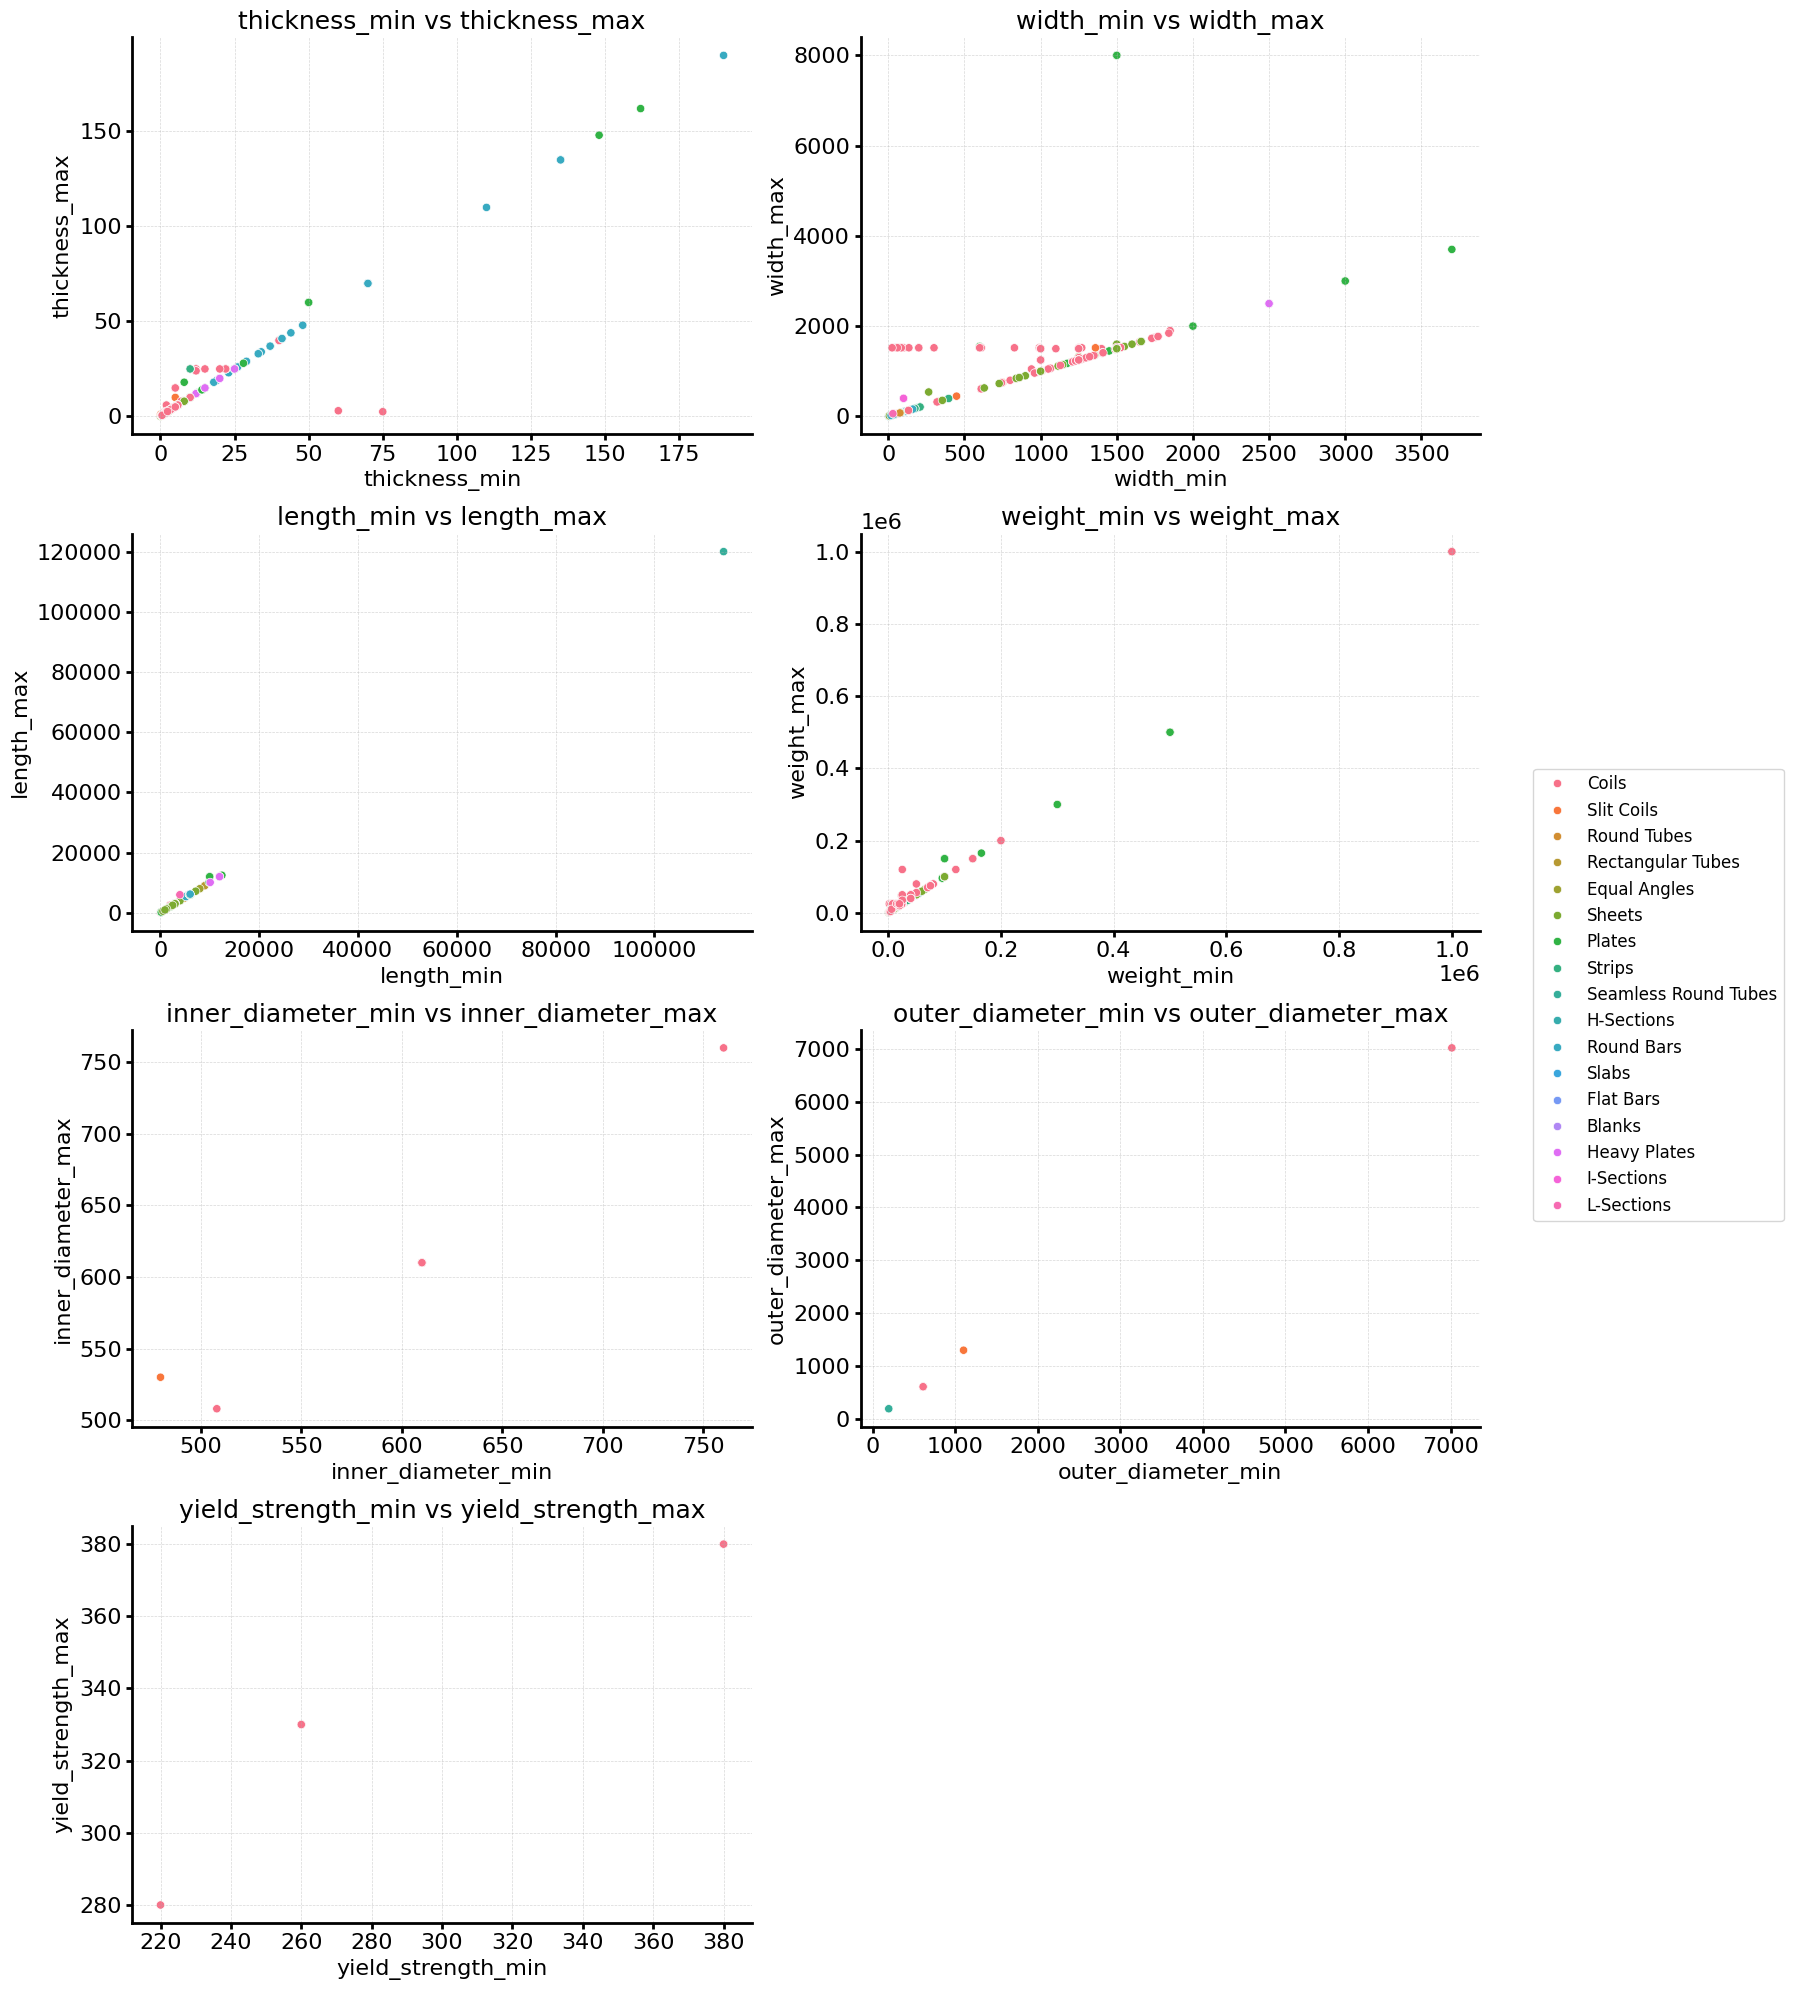

In [14]:
# Define your variable groups
var_groups = [
    ['thickness_min', 'thickness_max'],
    ['width_min', 'width_max'],
    ['length_min', 'length_max'],
    ['weight_min', 'weight_max'],
    ['inner_diameter_min', 'inner_diameter_max'],
    ['outer_diameter_min', 'outer_diameter_max'],
    ['yield_strength_min', 'yield_strength_max']
]

# Visualize relationships between dimensions variable groups
plot_scatter_for_variable_groups(df_merged, var_groups)

<Axes: >

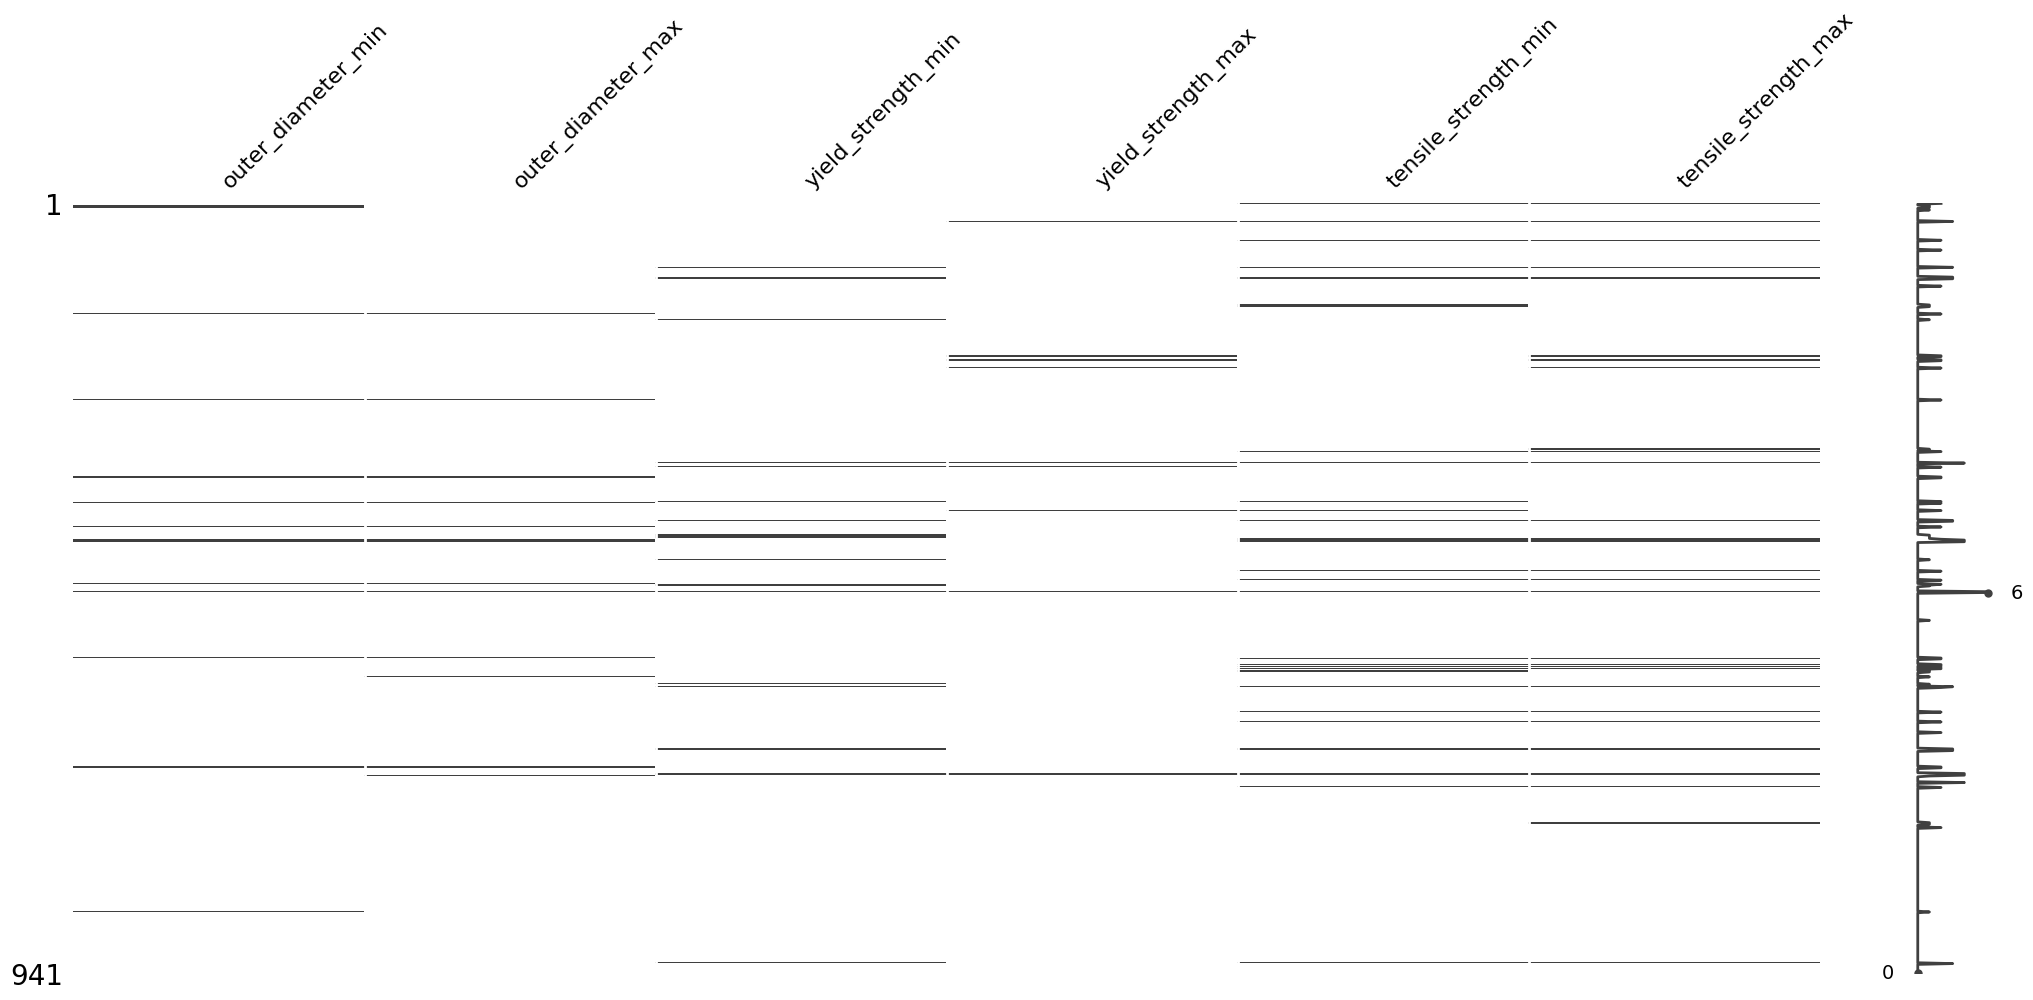

In [15]:
# Plot sparse variables
import missingno
missingno.matrix(df_merged.loc[:, ['outer_diameter_min', 'outer_diameter_max', 'yield_strength_min', 'yield_strength_max', 'tensile_strength_min', 'tensile_strength_max']])

**Fix Misclassified Diameters**:

- I identify records where outer_diameter_min = 610.0 (probably a data entry error, after assessment on internet)
- I move these values to inner_diameter_min/max = 610.0 
- I set the incorrect outer_diameter_min/max values to NaN

In [29]:
# Fix outer_diameter values

# outer_diameter = 610.0 is a mistake, it should be inner_diameter 
mask = df_merged['form'][df_merged['outer_diameter_min'] == 610.0].index
df_merged.loc[mask, ['inner_diameter_min', 'inner_diameter_max']] = 610.0
df_merged.loc[mask, ['outer_diameter_min', 'outer_diameter_max']] = np.nan


- **Pattern Analysis:** I observe that all records with inner_diameter_min = 610.0 belong to Coils, Slit Coils, and Strips forms only

- **Imputation Strategy:** I impute missing inner diameter values for these three form types with 610.0 (standard industry dimension)

- **Implementation:** I apply this imputation to records where form is in ['Coils', 'Slit Coils', 'Strips'] and inner_diameter is missing

In [17]:
# Inputting missing values for inner_diameter_min and inner_diameter_max
print('- Inspecting inner_diameter_min values equal to 610.0')
print(df_merged.loc[df_merged['inner_diameter_min'] == 610.0, "form"].value_counts())
print('\n- Values with inner_diameter_min equal to 610.0 are only Coils, Slit Coils, and Strips.\n--> I decided to impute inner_diameter missing values for these 3 forms with 610.0')

inner_diameter_mask = (df_merged['form'].isin(['Coils', 'Slit Coils', 'Strips']) & 
        df_merged['inner_diameter_min'].isna())

df_merged.loc[inner_diameter_mask, 'inner_diameter_min'] = 610
df_merged.loc[inner_diameter_mask, 'inner_diameter_max'] = 610

- Inspecting inner_diameter_min values equal to 610.0
form
Coils         159
Slit Coils     11
Strips          5
Name: count, dtype: int64

- Values with inner_diameter_min equal to 610.0 are only Coils, Slit Coils, and Strips.
--> I decided to impute inner_diameter missing values for these 3 forms with 610.0


**Clean Thickness**
- **Logical Error Correction**: I identify records where `thickness_min > thickness_max` (impossible)  
- **Correction Strategy**: I set `thickness_min` equal to `thickness_max` to resolve the inconsistency


In [18]:
# wrong thickness spotted (thickness_min > thickness_max)
mask =df_merged[df_merged['thickness_min'] > df_merged['thickness_max']].index
print(f"Found {len(mask)} entries with thickness_min > thickness_max. I will set thickness_min = thickness_max for these entries.")
df_merged.loc[mask, ['thickness_min']] = df_merged.loc[mask, ['thickness_max']].values

Found 2 entries with thickness_min > thickness_max. I will set thickness_min = thickness_max for these entries.


**Clean Width**  
- **Outlier Identification**: I find unrealistic width values of 8000 (likely data entry error)
- **Correction Method**: I replace `width_max = 8000` with the corresponding `width_min` value


In [19]:
# founded unrealistic width of 8000, I input these values with the width min 
mask = df_merged['width_max'] == 8000
df_merged.loc[mask, 'width_max'] = df_merged.loc[mask, 'width_min']

**Clean Length**
- **Outlier Detection**: I identify length values > 50000 (unrealistically large measurements)
- **Unit Correction**: I suspected that the error was due to an additional 0 accidentaly entered.  
I divide both `length_min` and `length_max` by 10 to correct apparent unit errors


In [20]:
# Fix wrong max and min length by dividing by 10 those > 50000
mask = df_merged['length_min'] > 50000
df_merged.loc[mask, 'length_min'] = df_merged.loc[mask, 'length_min'] / 10
df_merged.loc[mask, 'length_max'] = df_merged.loc[mask, 'length_max'] / 10


**Clean Weight**
- **Unrealistic Values**: I identify weight values > 200000 (implausible for steel materials)
- **Unit Adjustment**: Also here I suspected an accidental extra 0. I divide both `weight_min` and `weight_max` by 10 to correct scale errors


In [21]:
# Some weight are unrealistics. I will divide by 10 those weight > 200000
mask = df_merged['weight_max'] > 200000
df_merged.loc[mask, 'weight_min'] = df_merged.loc[mask, 'weight_min'] / 10
df_merged.loc[mask, 'weight_max'] = df_merged.loc[mask, 'weight_max'] / 10


**Singleton Dimensions**
- **Missing Value Handling**: I apply `fill_singleton_dimensions` function to all dimensional variables
    - This function set missing min/max values equal to each other when only one boundary is available
- **Variables Processed**: thickness, width, length, weight, inner_diameter, outer_diameter, yield_strength, tensile_strength

In [22]:
# Manage singleton dimensions 
dimension_cols = [
    'thickness',
    'width',
    'length',
    'weight',
    'inner_diameter',
    'outer_diameter',
    'yield_strength',
    'tensile_strength'
]
    
for col in dimension_cols:
    df_merged = fill_singleton_dimensions(df_merged, col)

- The plot shows the variables after the cleaning

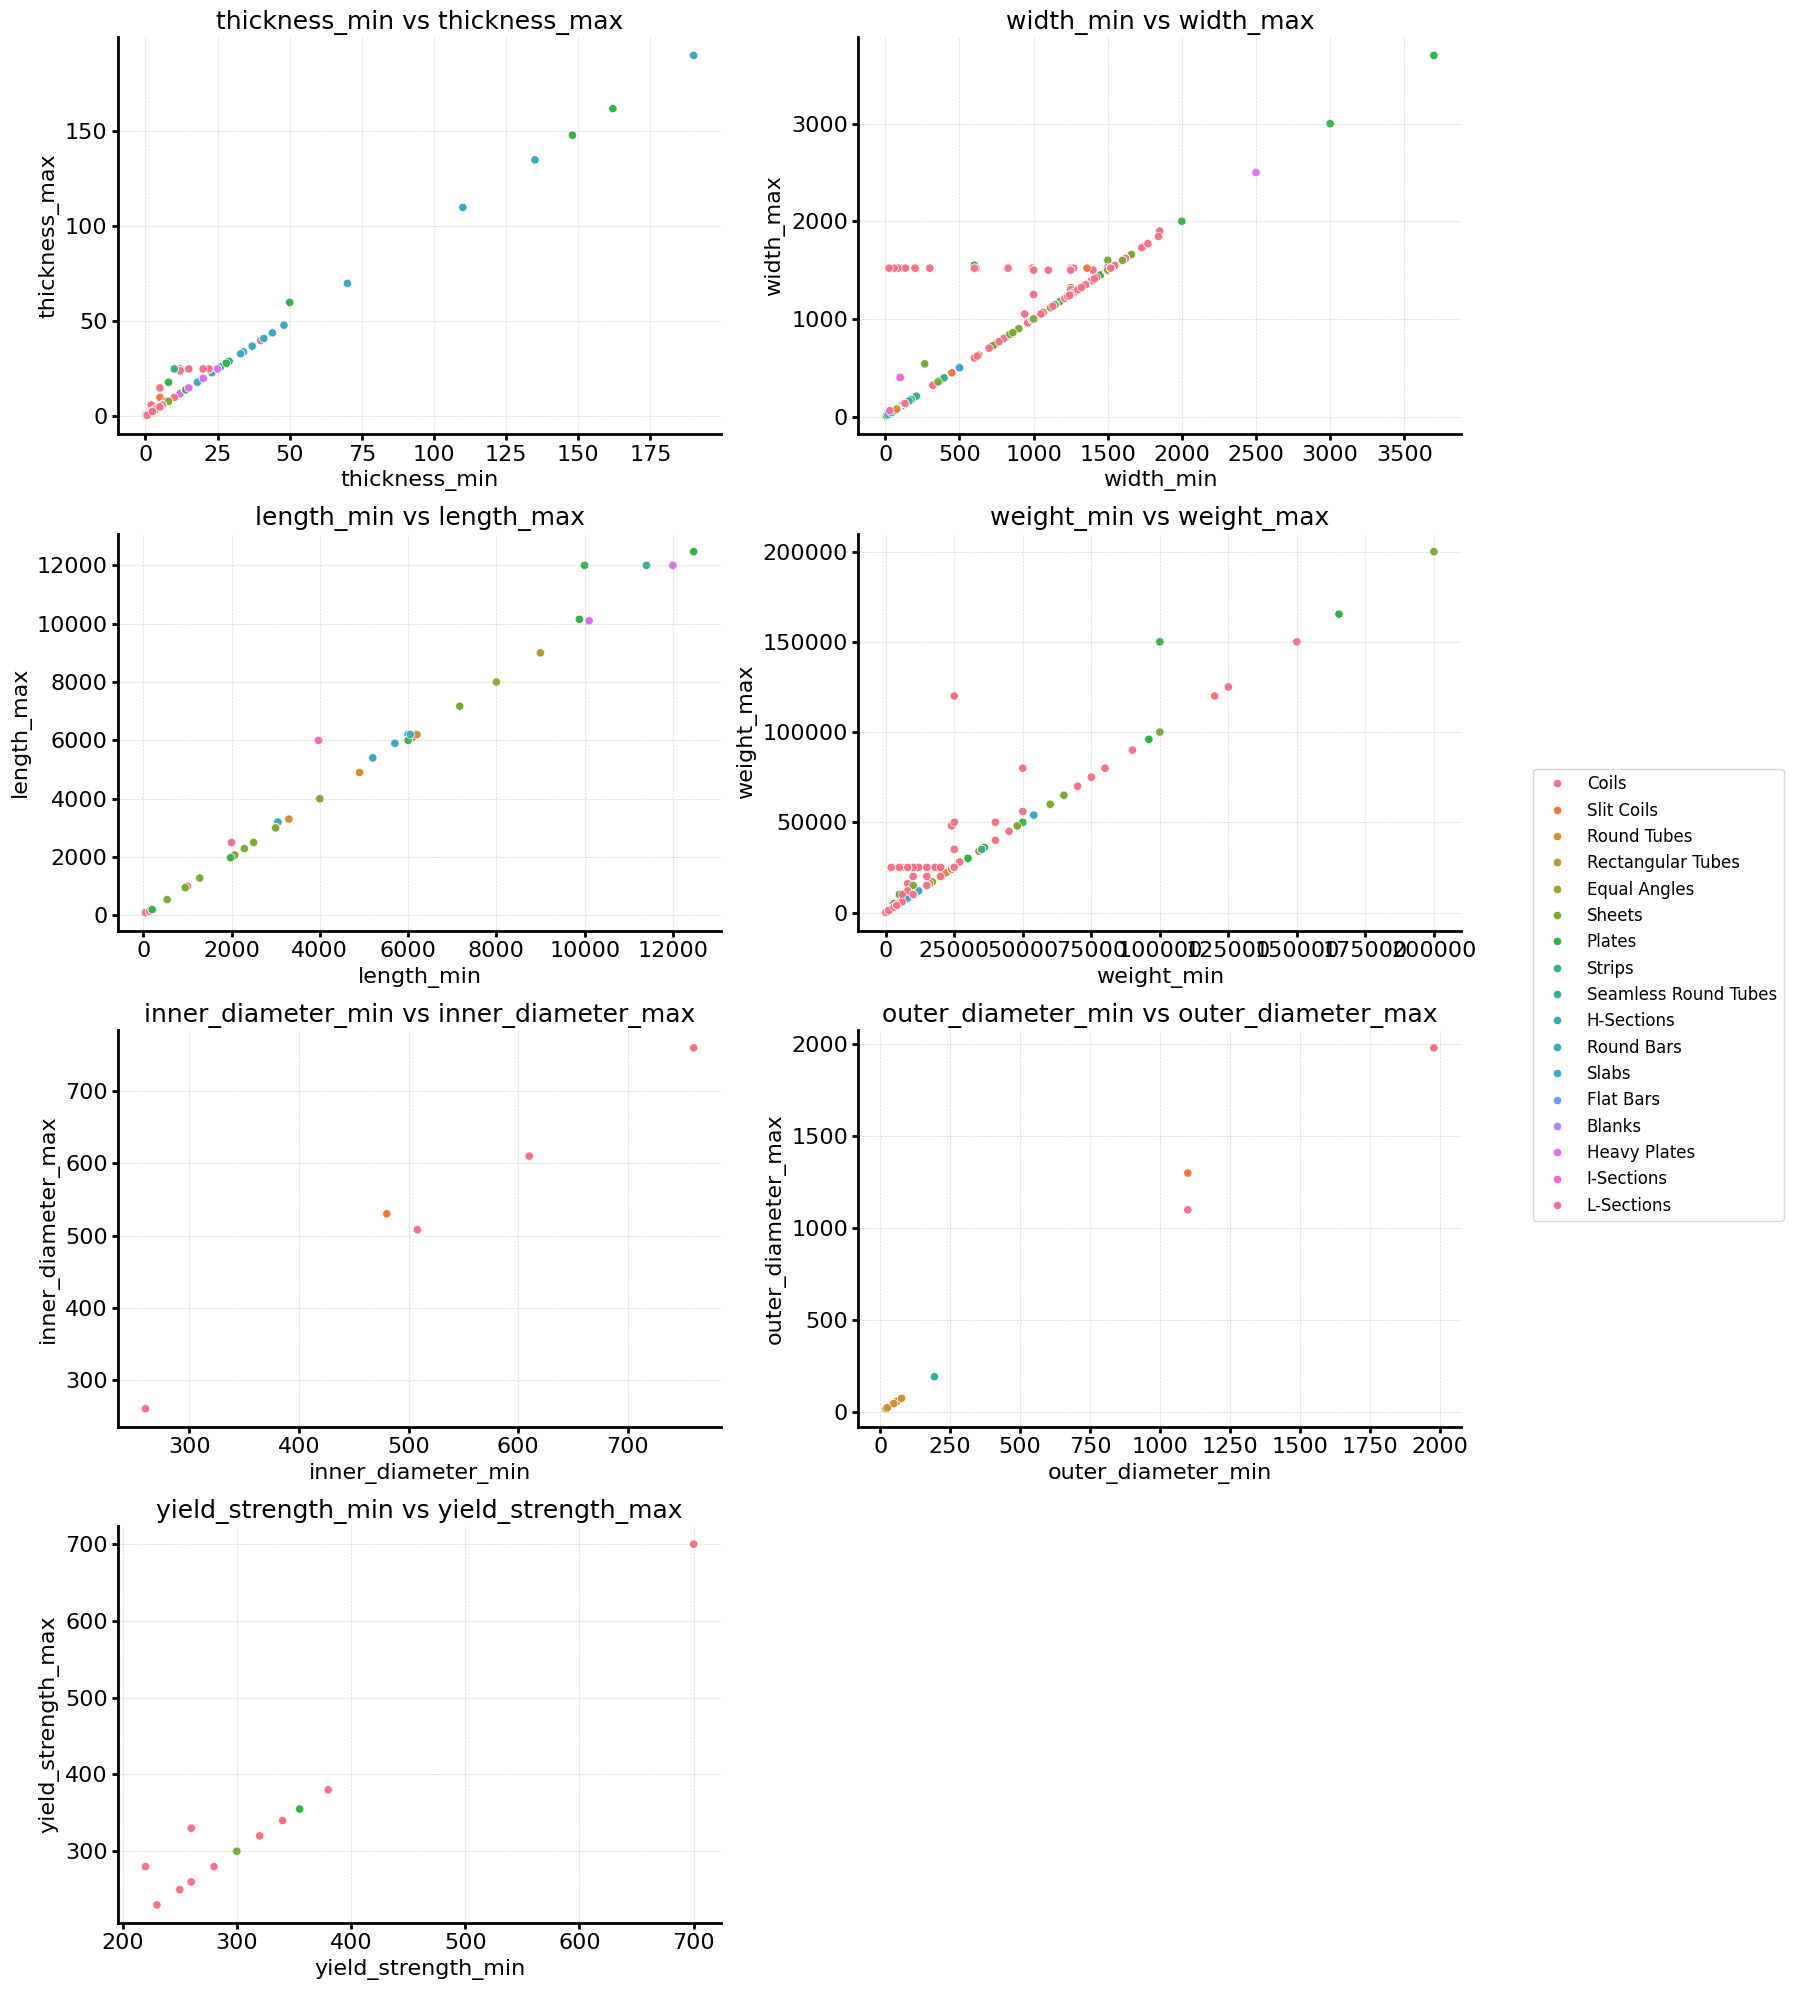

In [23]:
plot_scatter_for_variable_groups(df_merged, var_groups)

In [24]:
# save to csv
# df_merged.to_csv('outputs/task_2_output.csv', index=False)

## 3) Similarity Analysis

#### Variable Selection
- **Grade Properties**: I select 12 properties (carbon, manganese, silicon, sulfur, phosphorus, vanadium, aluminum, titanium, niobium, tensile strength, yield strength, elongation)
  - I exclude variables with >85% sparsity
- **Categorical Variables**: I include 5 surface and form characteristics (coating, finish, surface_type, surface_protection, form)  
- **Dimensions**: I use 5 physical measurements (length, width, thickness, weight, inner_diameter)
  - I exclude variables with very high sparsity  
<br>
--- 

### Analysis Parameters & Computation Methods

#### Grade Properties Similarity
- **Distance Method**: I apply euclidean distance for normalized property vectors
  - **Logic**: I tested cosine similarity which produced slightly more conservative results. No strong difference between the two metrics
- **Data Normalization**: I normalize each property column to [0,1] range using min-max scaling (due to different ranges across variables)
- **Missing Value Handling**: I skip columns with missing values for each pairwise comparison
- **Edge Cases**: I set similarity to 1.0 when both vectors are zero, 0.0 when only one is zero
  - I reasoned that zero value means that the steel doesn't contain that specific property

#### Categorical Similarity
- **Vectorized Matching**: I use broadcasting to create pairwise comparison matrices for each categorical variable
- **NaN Handling**: I set NaN-NaN comparisons to 1.0 (similar), NaN-value comparisons to 0.0 (dissimilar)
- **Logic**: I treat missing categorical data as meaningful similarity (both materials lack specification) rather than dissimilarity
- **Aggregation**: I sum matches across all categorical variables and average by the number of variables

#### Dimensional Similarity  
- **Similarity Method**: I use IoU (Intersection over Union) for dimensional range overlaps
  - **Logic**: I use IoU as overlap measurement was explicitly requested. Since most intervals are singletons or non-overlapping, values are typically 0 or 1. Probably a distance metric would be better (implemented in further explorations)
- **Range Overlap**: I compute IoU for dimensional ranges (min/max pairs)
- **Averaging**: I sum similarities across all dimensions and divide by dimension count

#### Overall Strategy
- **Weight Strategy**: I set equal weights [1,1,1] across all three component types
  - **Logic**: I assume equal importance across material properties. In the further explorations I try also different weights combinations

In [25]:
# Set variable groups for similarity analysis
grade_properties_vars = ['carbon_C_mid', 'manganese_Mn_mid', 'silicon_Si_mid', 'sulfur_S_mid', 'phosphorus_P_mid', 'vanadium_V_mid', 'aluminum_Al_mid',
                         'titanium_Ti_mid', 'niobium_Nb_mid','tensile_strength_Rm_mid', 'yield_strength_RE_RP0.2_mid', 'elongation_A%_mid']
categorical_vars = ['coating_x', 'finish', 'surface_type', 'surface_protection', 'form']
dimensions_vars = ['length', 'width', 'thickness', 'weight', 'inner_diameter']

# Run similarity analysis
similarity_matrix = run_similarity_analysis(df_merged, dimensions_vars, categorical_vars, grade_properties_vars, 
                           distance_type='euclidean', similarity_type='iou', 
                           ablations=[], weights=[1, 1, 1])

Computing property similarities
Processing row 0/941
Processing row 250/941
Processing row 500/941
Processing row 750/941
Computing categorical similarities
Computing dimensional similarities


**Output Generation**

- **Top Similarity Extraction**: I extract the top 3 most similar materials for each entry from the similarity matrix
- **Format**: I export to CSV with columns for original RFQ_ID, similar RFQ_ID, and similarity scores

In [26]:
# Get top 3 similarities for each entry and create output CSV
top_n_indices, top_n_values = get_top_n_similarities(similarity_matrix, n=3)

output_path = Path.cwd().parent / 'Results' / 'top3.csv'
create_output_csv(df_merged, top_n_indices, top_n_values, output_path=output_path)

Similarity results saved to /Users/davide/Documents/Learning/Work Case Studies/Vanilla Steel/Results/top3.csv


## 4) Further Analyses

### Exploratory Analysis Setup
- **Data Sorting**: I sort data by grade to reveal clustering patterns of similar steel types in visualizations
- **Default Configuration**: I establish baseline parameters (euclidean distance, equal weights, no ablations) for systematic comparisons
- **Results Visualisation**: I plot the resulting similarity matrices for visual inspection

### Exploration Categories
- **Similarity Metrics**: I test baseline euclidean distance vs IoU dimensional overlap vs cosine similarity approaches
- **Ablation Studies**: I perform ablation by removing each component (dimensions/categories/properties) and to assess individual contributions  
- **Weighting Schemes**: I experiment with emphasis on different components - property-focused [3,1,1], category-focused [1,3,1], dimension-focused [1,1,3], and clustering-optimized [6,3,1]

### Observations
- **Similarity Comparison**: The differences are subtle. The combination of 'cosine similarity' and 'distance' (instead of 'iou') tends to return more evident clustering. This is most likely due to the strongest discriminative effect of these two metrics. Infact, 'cosine' tends to push values to the extremes while 'distance' can capture also values which doesn't overlap
- **Ablation and Weights Experiments**: Both explorations made evident that 'grade properties' is the most effective component in clustering the different steel categories. This can be explained by the fact that grade properties represent the steel’s inherent material identity, whereas dimensions and surface treatments are more variable and dependent on specific applications.
    - Also the fact that grades includes 12 variables (double as much as the others) can be a variables explaining the observations.

In [27]:
# Sort df_merged by 'grade' to reveal clustres of similar grades
df_sorted = df_merged.sort_values(by='grade').reset_index(drop=True)

# Define default parameters
default_params = {
    "distance_type": 'euclidean',
    "similarity_type": 'distance', 
    "ablations": [],
    "weights": [1, 1, 1],
    "df": df_sorted,
    "dimensions_vars": dimensions_vars,
    "categorical_vars": categorical_vars,
    "grade_properties_vars": grade_properties_vars
}

# Define explorations parameters
similarities_explorations = {
    "baseline": {"distance_type": 'euclidean', "similarity_type": 'distance'},  
    "iou": {"distance_type": 'euclidean', "similarity_type": 'iou'},
    "cosine": {"distance_type": 'cosine', "similarity_type": 'distance'},
}

ablation_explorations = {
        "no_dimensions": {"ablations": ["dimensions"]},
        "no_categories": {"ablations": ["categories"]}, 
        "no_properties": {"ablations": ["properties"]}
}

weights_explorations = {
    "max_grade_properties": {"weights": [3, 1, 1]},
    "max_categories": {"weights": [1, 3, 1]},
    "max_dimensions": {"weights": [1, 1, 3]},
    "clustering_optimized": {"weights": [6, 3, 1]}
}

Running analysis for: baseline
Computing property similarities
Processing row 0/941
Processing row 250/941
Processing row 500/941
Processing row 750/941
Computing categorical similarities
Computing dimensional similarities
Running analysis for: iou
Computing property similarities
Processing row 0/941
Processing row 250/941
Processing row 500/941
Processing row 750/941
Computing categorical similarities
Computing dimensional similarities
Running analysis for: cosine
Computing property similarities
Processing row 0/941
Processing row 250/941
Processing row 500/941
Processing row 750/941
Computing categorical similarities
Computing dimensional similarities
Running analysis for: no_dimensions
Computing property similarities
Processing row 0/941
Processing row 250/941
Processing row 500/941
Processing row 750/941
Computing categorical similarities
Running analysis for: no_categories
Computing property similarities
Processing row 0/941
Processing row 250/941
Processing row 500/941
Processing

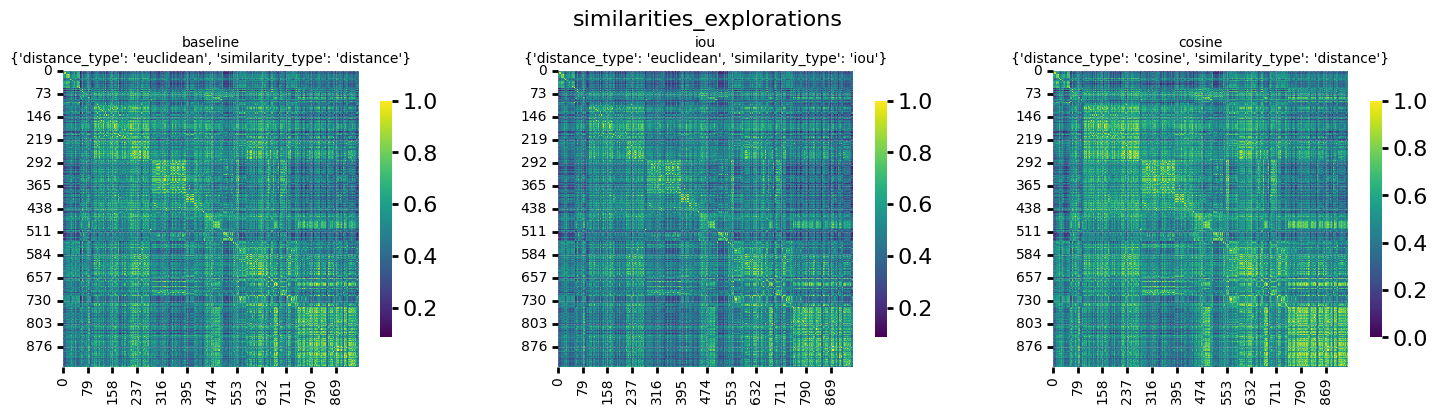

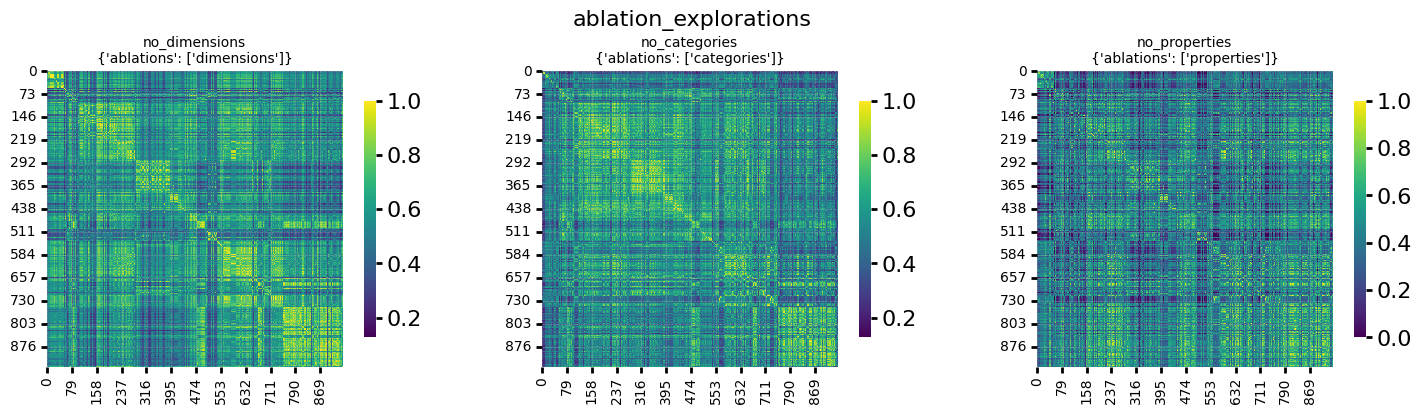

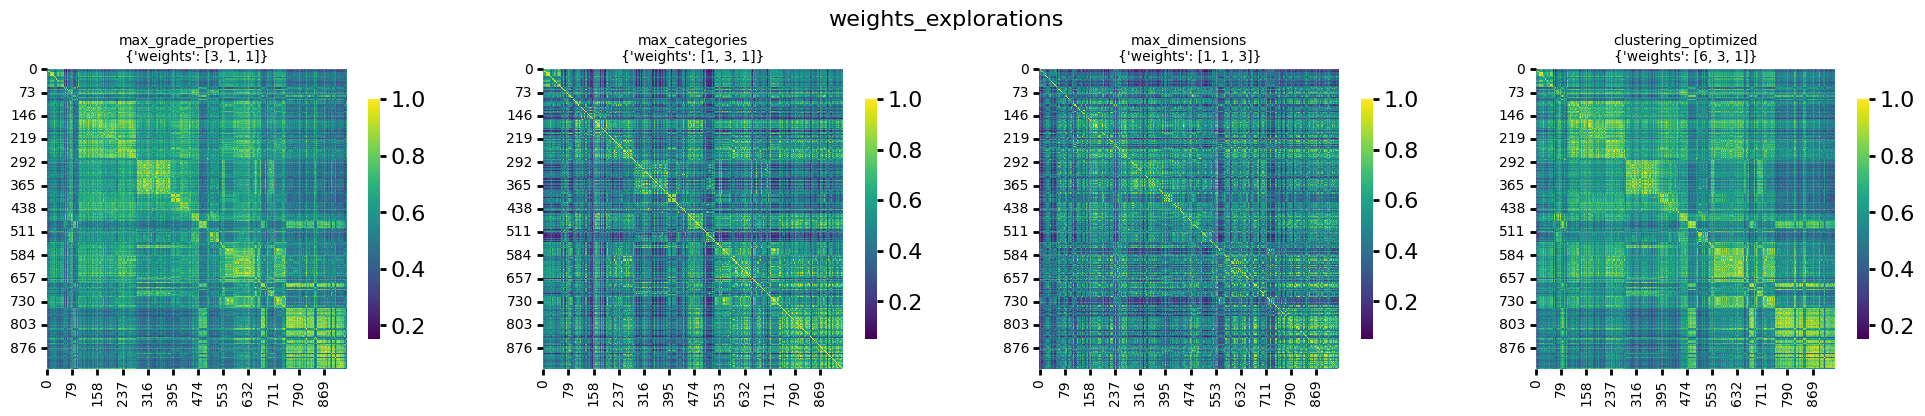

In [28]:
# Combine and run
all_explorations = [{**similarities_explorations}, {**ablation_explorations}, {**weights_explorations}]

matrices = {'similarities_explorations': {}, 'ablation_explorations': {}, 'weights_explorations': {}}
for expl_params, expl_name in zip(all_explorations, matrices.keys()):
    matrices[expl_name] = run_explorations(expl_params, default_params)

# Plot results
# Runtime ~45 seconds
plot_explorations(matrices, similarities_explorations, ablation_explorations, weights_explorations)